# 11-HUBO: Higher Order Unconstraint Binary Optimization

通常のイジングモデルまたはQUBOモデルに対して高次の項を導入したモデルを考えてみます。 具体的には２値のバイナリ変数$\sigma_{i} \in \{-1, +1\}$ または $\sigma_{i} \in \{0, 1\}$に対して次のようなエネルギー関数を導入してみましょう。

$$
H= c+\sum_{i} h_{i} \sigma_{i}+\sum_{i<j} J_{i j} \sigma_{i} \sigma_{j}+\sum_{i<j<k} K_{i, j, k} \sigma_{i} \sigma_{j} \sigma_{k}+\cdots,
\\
i=1,\ldots ,N
$$

ここで、添え字$i,j,k,\ldots$はバイナリ変数を指定するインデックスで、$1<= i,j,k,... <=N$の値を取ります。$c$は定数であり、0次の項に対応します。
このエネルギー関数の最小値を与える変数の組$(\sigma_{1} ,\sigma_{2} ,\ldots,\sigma_{N} )$を求める問題は、higher-order unconstrained binary optimization (HUBO)やpolynomial unconstrained binary optimization (PUBO)などど呼ばれています。以下ではHUBOで統一して呼称することにします。
この手の問題は通常のイジングモデルを自然に拡張したものとみなすことができ、例えば、量子化学の分野で現れます。
このチュートリアルでOpenJijを用いたHUBOの解法を紹介します。

## HUBOの定義

本チュートリアルでは、簡単のため、以下のような3次以下の項のみが現れる$N=3$変数の問題を考えます。以下ではバイナリ変数は$\{-1,+1\}$のスピン変数とします。

$$
H = -\sigma_1 -\sigma_1\sigma_2 +\sigma_1\sigma_2\sigma_3, \\ \sigma_i \in \{-1, +1\}
$$

OpenJijでこの問題を解くために、まずはこのエネルギー関数をpythonの辞書型で次のように表現します。
辞書型のkeyに相互作用に関わるスピン変数を指定するインデックス、valueに対応する相互作用の値を設定します。

In [1]:
# HUBOを定義します。
polynomial = {(1,): -1, (1,2): -1, (1,2,3): 1}

## HUBOの直接解法

通常HUBOを解く際は相互作用の次数を2次以下に落としたQUBOを生成してこれを解きますが、
OpenJijではHUBOをQUBOに変換することなく、以下のsample_huboメソッドを用いることで
直接SAで解を求めることができます。


In [2]:
import openjij as oj

# sample_huboメソッドを利用するためには、SASamplerメソッドを用いる必要があります。
sampler = oj.SASampler()

# sample_huboメソッドに投げます。
# sample_huboメソッドの第２引数vartypeは変数のタイプ、SPINもしくはBINARYを指定します。
# SPINでは{-1,1}、BINARYでは{0,1}が変数として指定されます。  
response = sampler.sample_hubo(polynomial, vartype="SPIN")
# 結果を表示します。
print(response)

   1  2  3 energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


$\sigma_1=+1,\;\sigma_2=+1,\;\sigma_3=-1$が解として得られていることが分かります。
このときのエネルギーは-3であり、これは最適解です。

なお、sample_huboメソッドは、辞書のkeyとして数値以外も扱うことができます。

In [3]:
# 辞書のkeyは数値以外も扱うことができます。
# HUBOを定義します。
polynomial_ = {('a',): -1, ('a', 'b'): -1, ('a', 'b', 'c'): 1}

# sample_huboメソッドに投げます。
response = sampler.sample_hubo(polynomial_, vartype="SPIN")
# 結果を表示します。
print(response)

   a  b  c energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


## QUBO変換による解法

HUBOを解く方法の一つとして、3次以上の高次の項を２次以下に変換して対応するQUBOを構成しこれを解くというものがあります。
この章ではその方法を説明します。

3次相互作用から対応するQUBOを生成するためにD-Waveのdimodというライブラリを使います。
ここで、5.0に指定されているペナルティの大きさ(strength)は、高次相互作用を２次以下に変換する際に生じた制約条件に対するペナルティで、小さすぎると生成したQUBOの最適解がもとのHUBOと一致しなくなります。逆に大きすぎるとそもそも最適解が得られなくなってしまいます。実際上、どれくらいの値を指定すればいいのかというのは難しい問題ですが、ここでは5.0に指定しています。


In [4]:
import dimod

# HUBO、strengthの大きさ、変数のタイプを指定して対応するquadraticモデルを生成します。
bqm_dimod = dimod.make_quadratic(poly=polynomial, strength=5.0, vartype="SPIN")
print('0次の項:', bqm_dimod.offset)
print('1次の項:', dict(bqm_dimod.linear))    # bqm.linearはpythonのdictに変換して表示します。
print('2次の項:', dict(bqm_dimod.quadratic)) # bqm.quadraticもpythonのdictに変換して表示します。

0次の項: 10.0
1次の項: {1: -3.5, '1*2': -3.5, 3: 0.0, 2: -2.5, 'aux1,2': -5.0}
2次の項: {('1*2', 1): 2.5, (3, '1*2'): 1.0, (2, 1): 2.5, (2, '1*2'): 2.5, ('aux1,2', 1): 5.0, ('aux1,2', '1*2'): 5.0, ('aux1,2', 2): 5.0}


見ての通りですが、もとの変数 $\sigma_1,\sigma_2,\sigma_3$ に加えて $\sigma_{"1∗2"}$、$\sigma_{"\rm aux1,2"}$ という２つの文字列で表現された変数が現れています。一般にHUBOをQUBOに変換すると変数の数、相互作用の数が増えてしまいます。

今回のケースではHUBOの場合の変数が3個、相互作用の数も3個でしたが、QUBOに変換することで、変数が5個、相互作用の数が7個に増えています。

このQUBOをopenJijのSAで解きたいわけですが、openJijでは数値と文字列が混在した変数は扱えないため、文字列を全て整数に変換する必要があります。
そのためにdimodのrelabel_variablesというメソッドを使って"1∗2"を4、"aux1,2"を5に変換します。

In [5]:
# 変換前と変換後の変数の対応関係を表した辞書を作ります。
mapping = {1: 1, 2: 2, 3: 3, '1*2': 4, 'aux1,2': 5}

# インデックスを1始まりの整数に変換します。
bqm_dimod.relabel_variables(mapping)

print('0次の項:', bqm_dimod.offset)
print('1次の項:', dict(bqm_dimod.linear))    # bqm.linearはpythonのdictに変換して表示します。
print('2次の項:', dict(bqm_dimod.quadratic)) # bqm.quadraticもpythonのdictに変換して表示します。
print('変数の対応関係:', mapping) # Relabelした後のインデックスと元のインデックスの対応関係を表示します。

0次の項: 10.0
1次の項: {1: -3.5, 4: -3.5, 3: 0.0, 2: -2.5, 5: -5.0}
2次の項: {(4, 1): 2.5, (3, 4): 1.0, (2, 1): 2.5, (2, 4): 2.5, (5, 1): 5.0, (5, 4): 5.0, (5, 2): 5.0}
変数の対応関係: {1: 1, 2: 2, 3: 3, '1*2': 4, 'aux1,2': 5}


それではこのQUBOをOpenJijを利用して解いてみましょう。

In [6]:
# dimodのbqmをOpenJijのBinaryQuadraticModelに変換します。
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_dimod.linear), dict(bqm_dimod.quadratic), bqm_dimod.offset, vartype="SPIN")
print(bqm_oj)
#　sampleメソッドを使ってSAを行います。
response = sampler.sample(bqm_oj)
print(response) 

BinaryQuadraticModel({5: -5.0, 4: -3.5, 2: -2.5, 1: -3.5}, {(4, 5): 5.0, (3, 4): 1.0, (1, 2): 2.5, (2, 5): 5.0, (2, 4): 2.5, (1, 4): 2.5, (1, 5): 5.0}, 10.0, Vartype.SPIN, sparse=False)
   1  2  3  4  5 energy num_oc.
0 -1 -1 -1 +1 +1   -1.0       1
['SPIN', 1 rows, 1 samples, 5 variables]


ここで得られたエネルギーは先程決めたstrengthの値によってはもとのhuboのエネルギーと対応してない可能性があります。
したがって、改めてエネルギーを計算する必要があります。
今回の場合、もともと変数は$\sigma_1,\sigma_2,\sigma_3$だけだったので、これらのスピン配位だけをつかってエネルギーを計算します。
ここでは$\sigma_1=+1,\sigma_2=+1,\sigma_3=-1$となっています。

In [7]:
# 元のHUBOの解に焼き直します。
hubo_configuration = {i+1: response.record[0][0][i] for i in range(3)}
print('対応するHUBOの解:', hubo_configuration)
print('対応するHUBOの解のエネルギー:', dimod.BinaryPolynomial(polynomial, "SPIN").energy(hubo_configuration))

対応するHUBOの解: {1: -1, 2: -1, 3: -1}
対応するHUBOの解のエネルギー: -1.0


ここではエネルギーとして-3を与えるスピン配位が得られました。これは今回のエネルギー関数の最適解になっています。

このことはdimodのExactPolySolverという厳密な最適解を求めるソルバーを使って実際に確認することができます。

In [8]:
# 元のHUBOの最適解を確認します。
sampleset = dimod.ExactPolySolver().sample_hising(h = {}, J = polynomial)
print('最適解:',sampleset.first.sample)
print('対応するエネルギー:',sampleset.first.energy)

最適解: {1: 1, 2: 1, 3: -1}
対応するエネルギー: -3.0


元のHUBOに対する最適解のエネルギーは確かに-3.0であることがわかります。
今回は変数の数が3個と少なかったため簡単に厳密解を求めることができますが、通常は厳密解を求めることは困難であることに注意してください。

## HUBOによる直接解法とQUBO変換による解法結果の比較

最後に, HUBOによる直接解法とQUBO変換による解法を比較してみましょう。 SAによるシミュレーションを100回行い、各シミュレーションで得られたエネルギーを比較してみます。
まずはsample_huboメソッドを用いて場合のエネルギーを求めます。

In [9]:
# SAによるシミュレーションを行う回数を指定します。
num_sa = 100

# num_readsというパラメータを設定すると、その回数分SAを独立に行います。
# 今回は100に指定します。デフォルトは1になっています。
response = sampler.sample_hubo(polynomial, vartype="SPIN", num_reads=num_sa)

# 得られたエネルギーをenergy_huboに代入します
energy_hubo = response.energies

次にQUBO変換を用いた解法によるエネルギーを求めます。
この場合、毎回huboのエネルギーを計算し直す必要があることに注意してください。

In [10]:
response = sampler.sample(bqm_oj, num_reads=num_sa)

# 得られたエネルギーをenergy_quadに代入します
energy_quad = []
for i in range(num_sa):
    hubo_configuration = {j+1: response.record[i][0][j] for j in range(3)}
    energy_quad.append(dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration))

得られた100回分の結果をヒストグラムにして比較してみます。

Text(0, 0.5, 'Frequency')

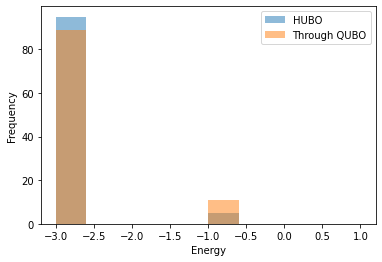

In [11]:
import matplotlib.pyplot as plt
plt.hist(energy_hubo, label='HUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.hist(energy_quad, label='Through QUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

HUBOを直接解いた方がQUBO変換をもちいた解法に比べてわずかに多く最適解が得られています。
ただしこの問題では例えばstrengthを1に設定すると常にQUBO変換する解法で最適解が得られます。
つまりはじめに設定したstrength=5という値が大きすぎたということです。
実際に確認してみましょう。

Text(0, 0.5, 'Frequency')

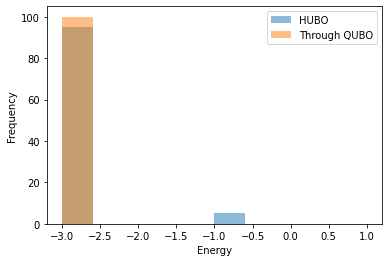

In [12]:
# strengthを1に設定します。
bqm_dimod = dimod.make_quadratic(poly=polynomial, strength=1.0, vartype="SPIN")

#以下同じことを繰り返します
bqm_dimod.relabel_variables(mapping)
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_dimod.linear), dict(bqm_dimod.quadratic), bqm_dimod.offset, vartype="SPIN")
response = sampler.sample(bqm_oj, num_reads=num_sa)

energy_quad = []
for i in range(num_sa):
    hubo_configuration = {j+1: response.record[i][0][j] for j in range(3)}
    energy_quad.append(dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration))
    
plt.hist(energy_hubo, label='HUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.hist(energy_quad, label='Through QUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

確かにQUBO変換による解法で常に最適解が得られています。
ただし、最適なstrengthの値は事前に分からないことに注意してください。
今の場合strength=1として最適解が得られていますが、一般のHUBOに対して適切なstrengthを決定することは難しい問題です。
また、QUBO変換を行うと、変数の数や相互作用の数が増えてしまうことも問題です。これにより余分なメモリが必要になっています。